In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import h5py

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

from pathlib import Path

from tqdne.utils import load_model_by_name, generate_data, get_samples, plot_waveform_and_psd, plot_waveforms, plot_by_bins, plot_log_envelope_bins, _get_cond_params_dict
from tqdne.conf import Config
from tqdne.metric import *

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# TODO:
* smaller figures 

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else: 
    device = torch.device('cpu')

torch.cuda.is_available(), device

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


(False, device(type='cpu'))

# GM0 Performance Evaluation

In [3]:
config = Config()

# Select the signal length
signal_length = config.signal_length 

# Set the number of channels of the desired output signal  
n_channels = config.num_channels

# Set the sampling frequency
fs = config.fs

# Set the conditioning parameters range
cond_params_range = config.conditional_params_range

In [4]:
!ls /store/sdsc/sd28/models/GM0/diffusion/1D-UNET-DDPM-envelope/

'name=0_epoch=0-val_loss=1.25.ckpt'   'name=0_epoch=85-val_loss=0.37.ckpt'
'name=0_epoch=1-val_loss=1.24.ckpt'   'name=0_epoch=86-val_loss=0.37.ckpt'
'name=0_epoch=79-val_loss=0.37.ckpt'  'name=0_epoch=87-val_loss=0.37.ckpt'
'name=0_epoch=82-val_loss=0.37.ckpt'


In [5]:
# Choose a model to load by the available names described in the documentation
# Choose a checkpoint from /store/sdsc/sd28/models/GM0/diffusion/COND-1D-UNET-DDPM-envelope/

# NOTE: the following model don't consider conditioning inputs 
model_path_str = "/store/sdsc/sd28/models/GM0/diffusion/1D-UNET-DDPM-envelope/name=0_epoch=87-val_loss=0.37.ckpt"

model, model_data_repr = load_model_by_name('diffusion_1d', map_location=device, path=Path(model_path_str))
model.eval()

print(model)

TypeError: SignalWithEnvelope.__init__() missing 1 required positional argument: 'dataset_stats_dict'

Let's generate a batch of data:

In [6]:
# Select the batch size
batch_size = 32


In [7]:
# Insert values for the conditional input parameters.
# Please read generate_cond_inputs documentation (in utils.py) to understand the structure of cond_input_params dictionary
cond_input_params = {
    "hypocentral_distance": [10, 100, 150],
    "is_shallow_crustal": [0],
    "log10snr": [0],
    "magnitude": [2, 1, 3, 7],
    "vs30": None,
}

#data = generate_data(model, model_data_repr, batch_size, cond_input_params, device=device.type)
#data['cond'].shape, data['cond'].shape

#DEBUG
import pickle

from tqdne import representations 
with open('data.pickle', 'rb') as f:
    data, cond_input = pickle.load(f)
    data = representations.to_numpy(data)
    cond_input = representations.to_numpy(cond_input)
    data = {'waveforms': np.array(data), 'cond': np.array(cond_input)}

     
        
data['waveforms'].shape, data['cond'].shape

((128, 3, 5472), (128, 5))

## Single Sample Visualization

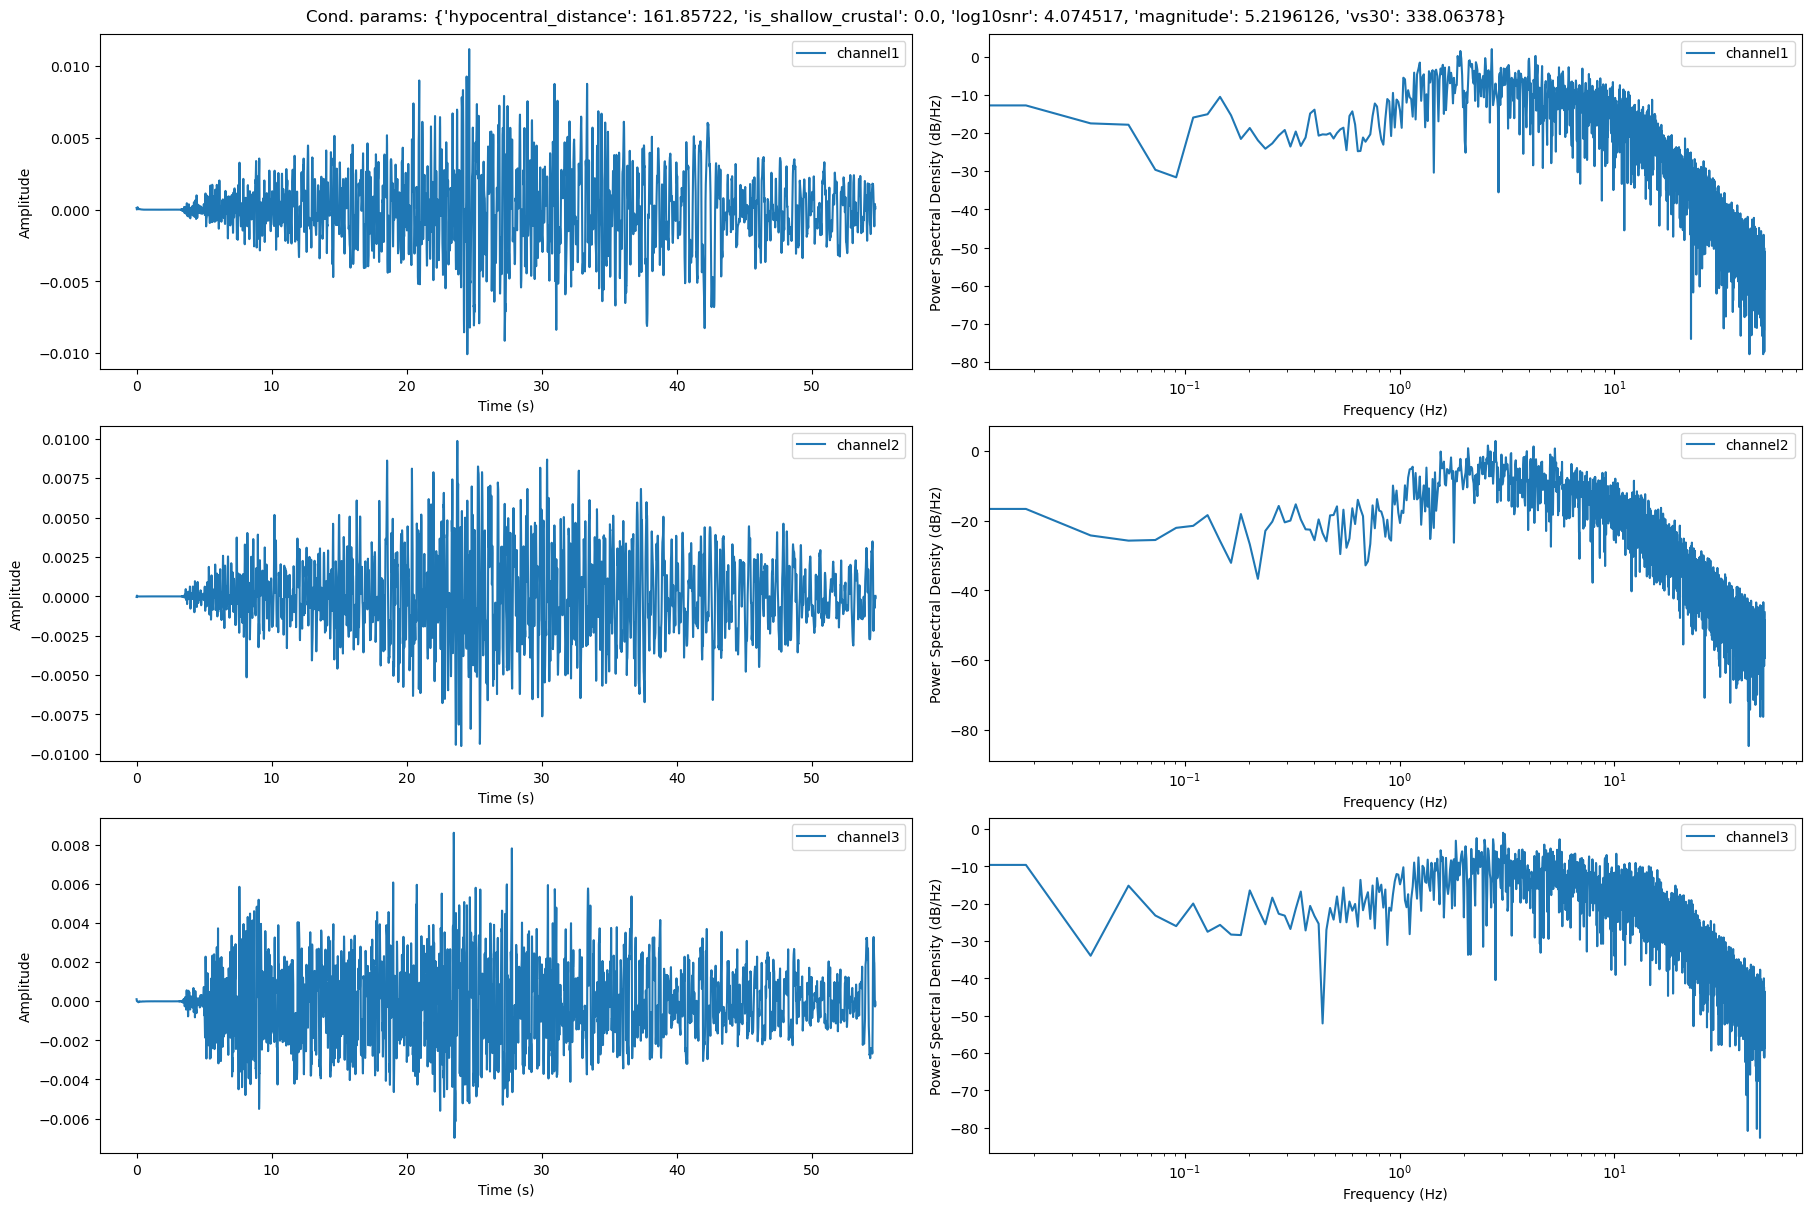

In [8]:
plot_waveform_and_psd(get_samples(data, num_samples=1))

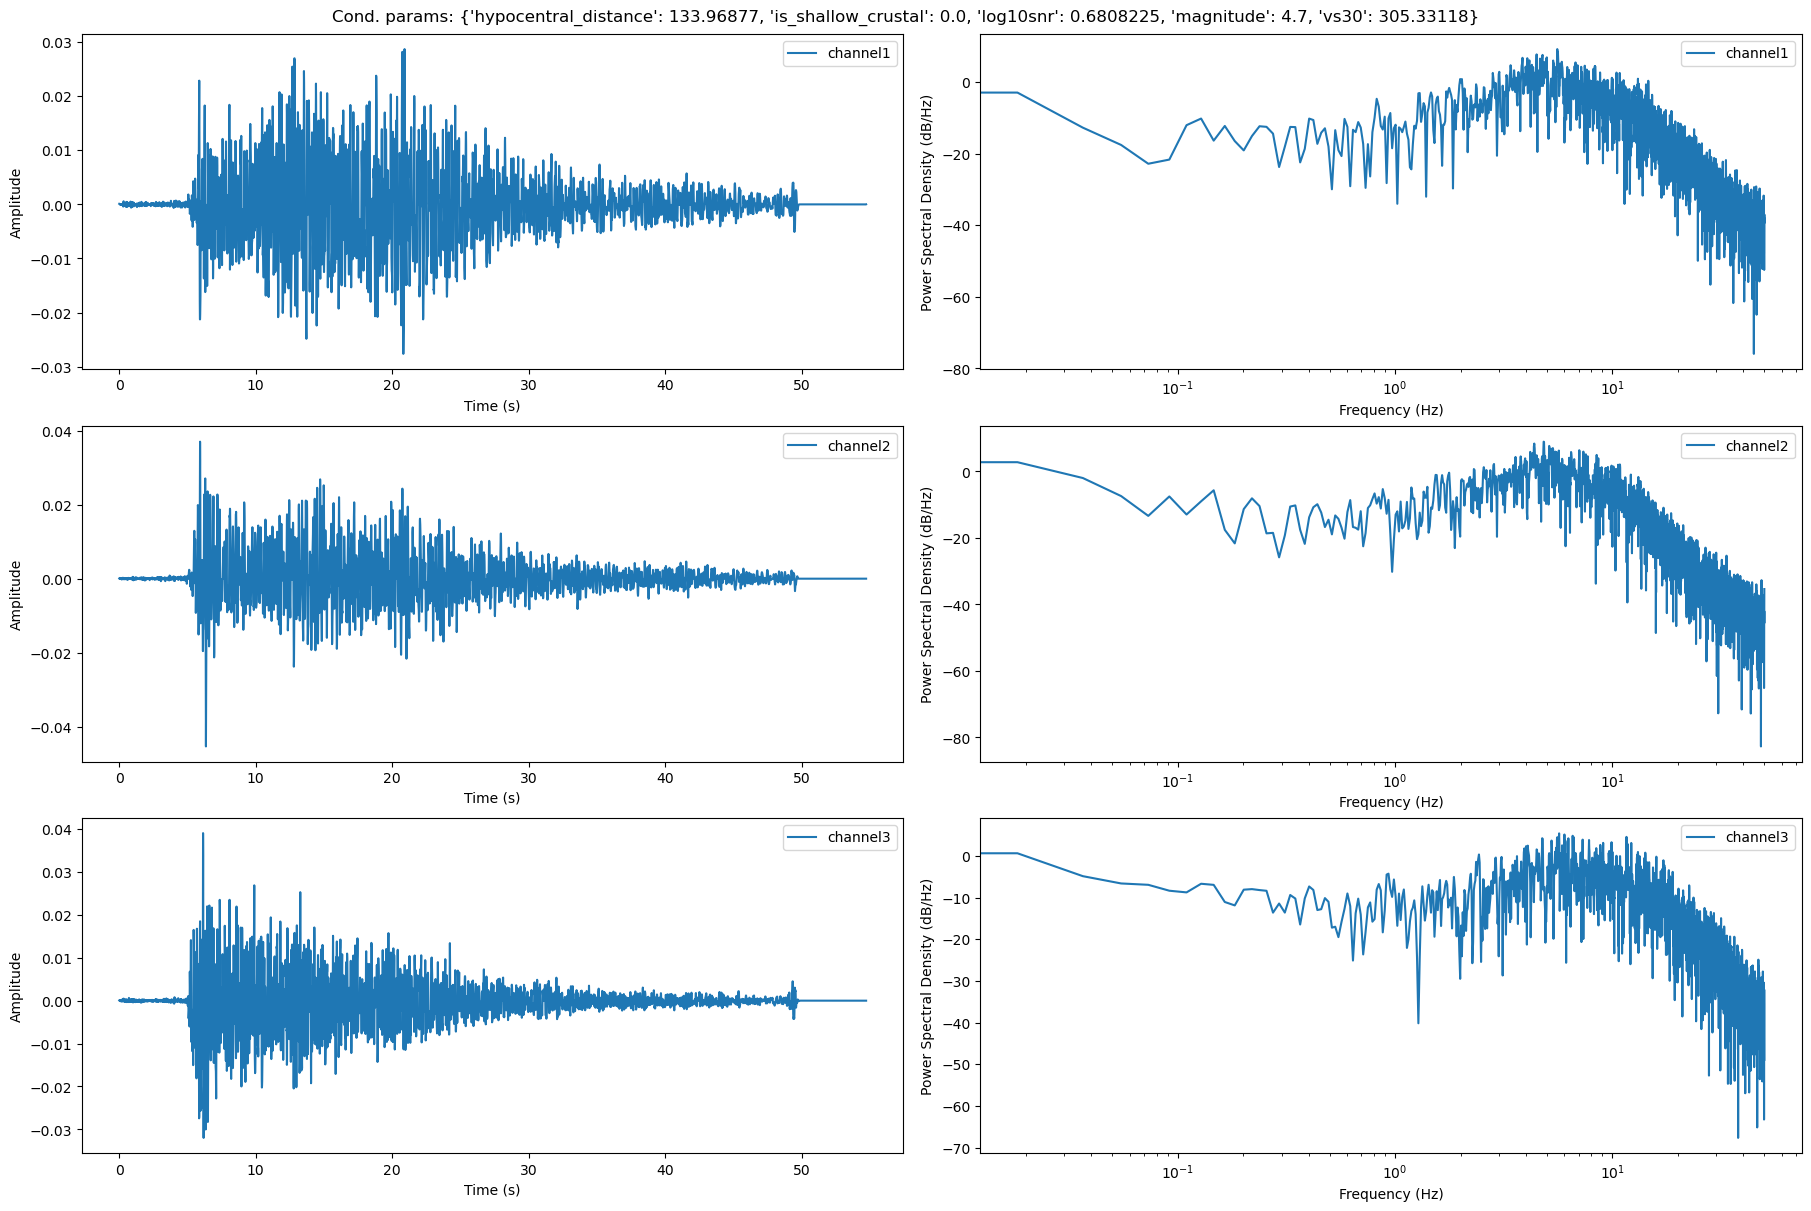

In [9]:
plot_waveform_and_psd(get_samples(data, indexes=[2]))

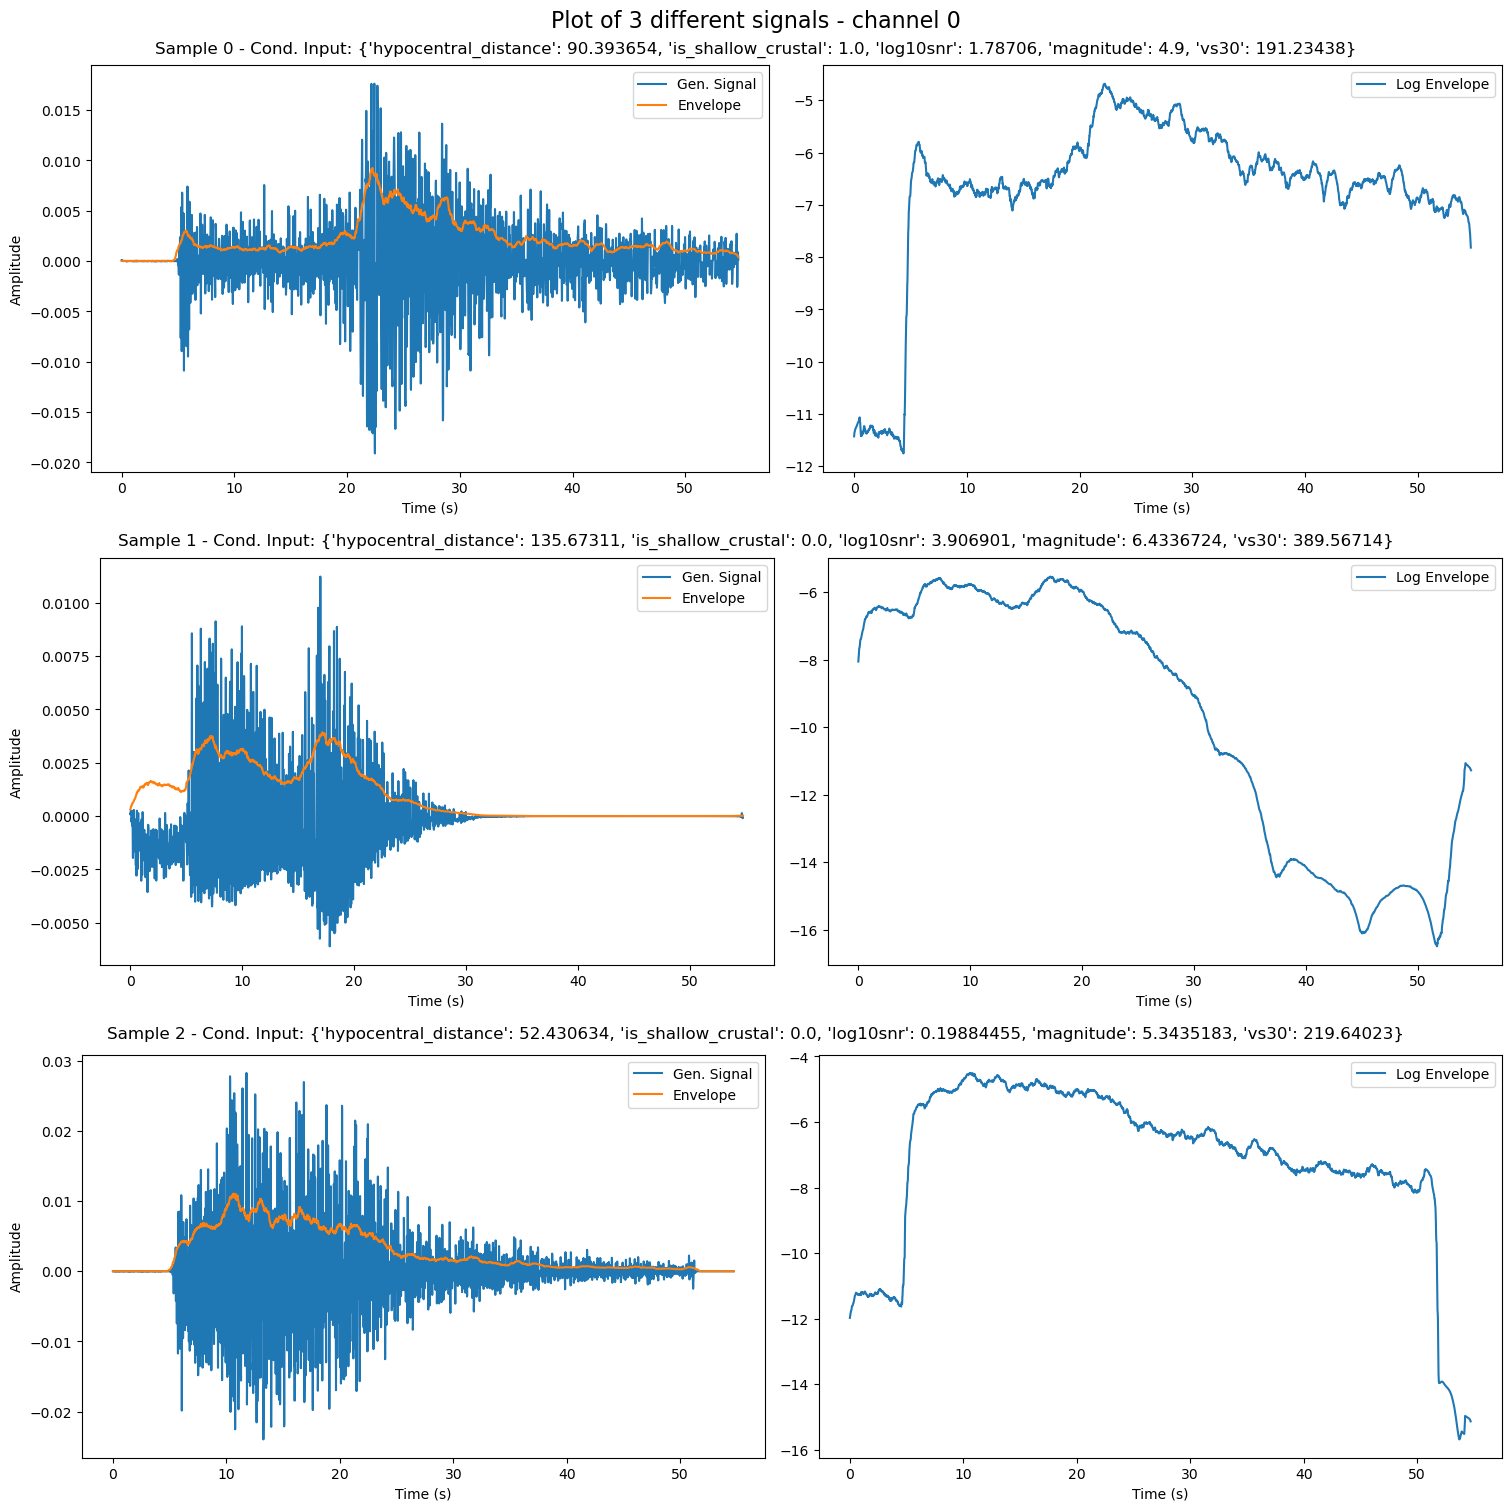

In [10]:
plot_waveforms(get_samples(data, num_samples=3), channel_index=0, plot_log_envelope=True)

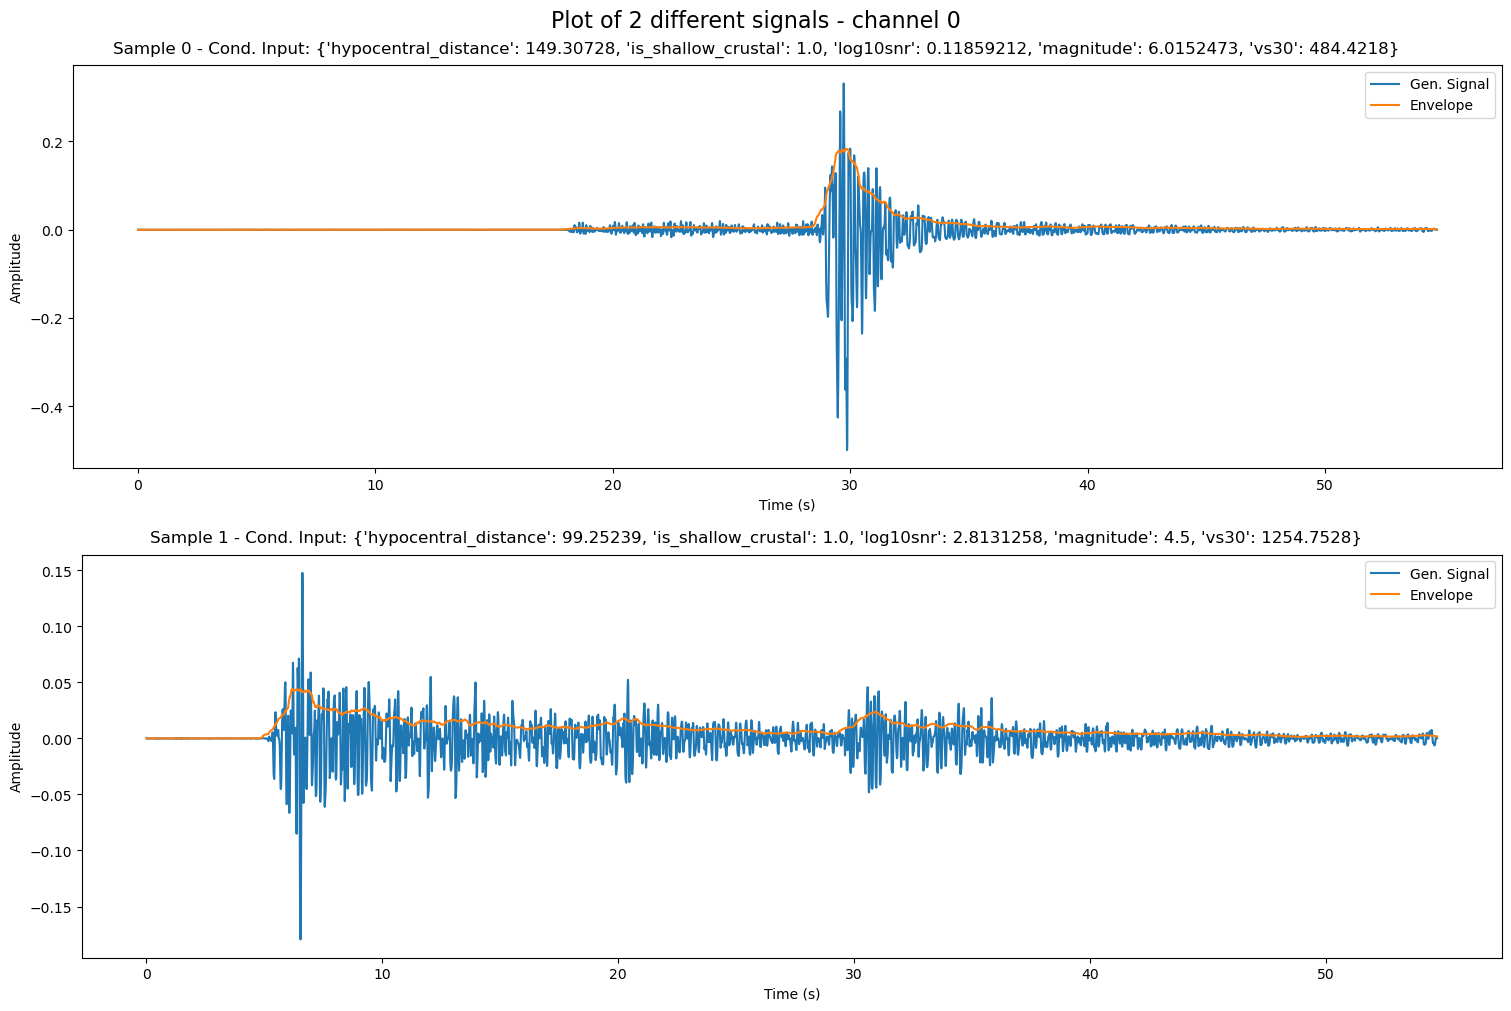

In [ ]:
plot_waveforms(get_samples(data, num_samples=2), channel_index=0, plot_log_envelope=False)

## Batch Statistics

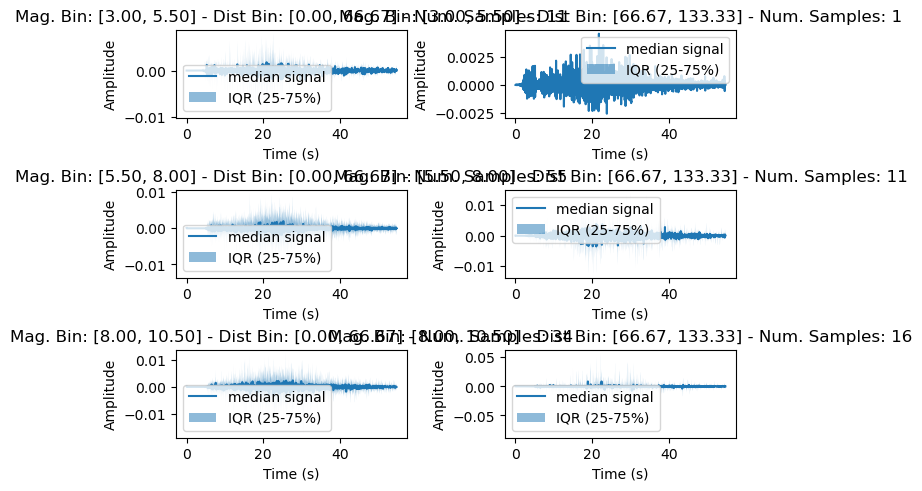

In [ ]:
plot_by_bins(data, num_magnitude_bins=2, num_distance_bins=3, plot='waveform')

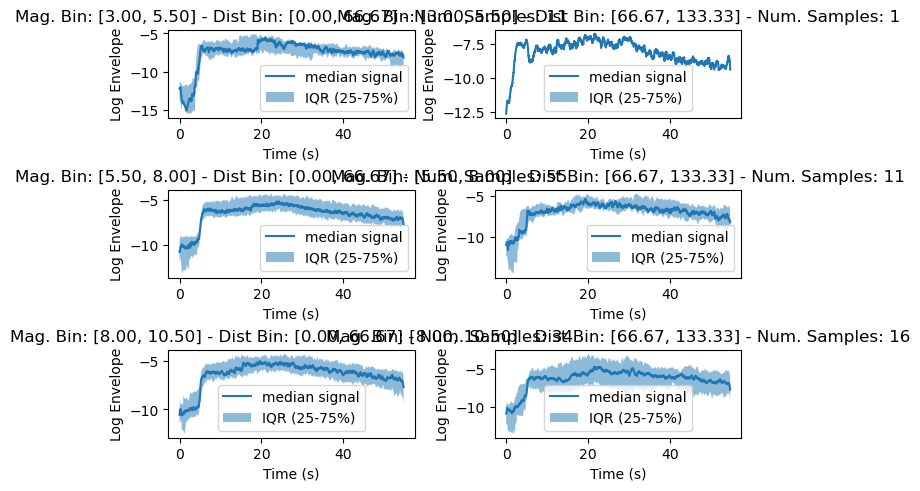

In [ ]:
plot_by_bins(data, num_magnitude_bins=2, num_distance_bins=3, plot='envelope')

## Evaluation

In [ ]:
# Load Test Data
test_dataset_path = config.datasetdir / config.data_test
with h5py.File(test_dataset_path,'r', locking=False) as test_file:
    test_waveforms = test_file["waveform"][:batch_size*8]
    test_features = test_file["features"][:batch_size*8]


In [ ]:
test_waveforms.shape, test_features.shape

((256, 3, 5501), (256, 5))

In [ ]:
# Generate waveforms with the same conditioning parameters of the test data
pred_data = generate_data(model, model_data_repr, batch_size=test_features.shape[0], cond_input=test_features, device=device.type)

pred_data['waveforms'].shape

NameError: name 'model' is not defined

In [ ]:
test_data = {"waveforms": test_waveforms, "cond": test_features}
test_data["waveforms"].shape, test_data["cond"].shape

((256, 3, 5501), (256, 5))

In [ ]:
plot_log_envelope_bins(distance_bins = [(21.6, 37.1), (39., 48.2), (50., 92.0), (93., 144.8)], magnitude_bins = [(3., 5.), (5.1, 6.), (6.1, 7.)], 
                       channel_index=0,
                        test_data = test_data, 
                        data = None, model = model, model_data_representation = model_data_repr)

NameError: name 'model' is not defined

In [ ]:
from tqdne.metric import PowerSpectralDensity, BinMetric

psd_metrics = [PowerSpectralDensity(fs, channel=channel) for channel in range(pred_data['waveforms'].shape[1])]

for psd_metric in psd_metrics:
    psd_metric.reset()
    psd_metric.update(pred={"generated": pred_data['waveforms']}, target={"representation": test_waveforms[:, :, : pred_data['waveforms'].shape[-1]], "cond": test_features})
    psd_metric.plot().show()
    
    bin_metric = BinMetric(psd_metric, num_mag_bins=3, num_dist_bins=3)
    bin_metric.reset()
    bin_metric.update(pred={"generated": pred_data['waveforms']}, target={"representation": test_waveforms[:, :, : pred_data['waveforms'].shape[-1]], "cond": test_features})
    bin_metric.plot().show()
    
    

In [ ]:
from tqdne.metric import LogEnvelope

log_env_metrics = [LogEnvelope(fs, channel=channel) for channel in range(pred_waveforms.shape[1])]

for log_env_metric in log_env_metrics:
    log_env_metric.reset()
    log_env_metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
    log_env_metric.plot().show()
    
    bin_metric = BinMetric(log_env_metric, num_mag_bins=3, num_dist_bins=3)
    bin_metric.reset()
    bin_metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
    bin_metric.plot().show()
    

In [ ]:
# TODO: widgets do not work

from tqdne.metric import PowerSpectralDensity, BinMetric
import ipywidgets as widgets
from functools import partial

metrics = {"Power Spectral Density": partial(PowerSpectralDensity, fs=config.fs)}

# Create a dropdown for selecting the metric
metric_dropdown = widgets.Dropdown(
    options=metrics.keys(),
    description='Metric:',
)

# Create a slider for selecting the channel
channel_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=2,
    step=1,
    description='Channel:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


# Bin plot checkbox
bin_plot_checkbox = widgets.Checkbox(
    value=False,
    description='Plot bins',
    disabled=False,
    indent=True,
)

# Create a slider for selecting the number of bins
num_bins_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=50,
    step=1,
    description='Num bins:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Function to update the plot
def update_plot(metric_name, bin_plot, num_bins=10, channel=0):
    metric = metrics[metric_name](channel=channel)
    if bin_plot:
        metric = BinMetric(metric, num_mag_bins=num_bins, num_dist_bins=num_bins)

    # Compute the metric
    metric.reset()
    metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
    metric.plot().show()

# Create interactive plot
widgets.interact(update_plot, metric_name=metric_dropdown, channel=channel_slider, bin_plot=bin_plot_checkbox, num_bins=num_bins_slider)



In [ ]:
print('done')

In [ ]:
# Save the data to obspy format
from obspy import Stream, Trace

# Convert waveforms to Trace objects
traces = [Trace(data=waveform, header={k:v for k, v in _get_cond_params_dict(pred_data["cond"][i])}) for i, waveform in enumerate(pred_data["waveforms"])]

# Create a Stream object
st = Stream(traces=traces)

# Save the Stream object to a file
st.write("generated_waveforms.mseed", format="MSEED", reclen=512, encoding="FLOAT64")
